In [104]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from IPython.display import display

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
#from imutils import paths #might need to install imutils package

#import shutil
#from pycocotools.coco import COCO
#from pathlib import Path
#from PIL import Image

#import torch
#import torchvision
#from torch.utils.data import Dataset
#from torchvision.transforms import ToTensor
#from torchvision.io import read_image    #could not import because running older version of torchvision in learn env

### Pulling data into Dataframes

In [2]:
# setting data paths and making list of each file type

path = '../Data/data/'

image_list = [x for x in os.listdir(path) if x.endswith('.jpeg')]

label_list = [x for x in os.listdir(path) if x.endswith('.txt')]

image_list.sort()
label_list.sort()

In [3]:
# checking image and label lists
image_list_check = [x[:-5] for x in image_list]
label_list_check = [x[:-4] for x in label_list]
                    
image_list_check == label_list_check

True

In [4]:
# creating initial dataframe from txt files (YOLO format)
df = pd.DataFrame(columns=['image_file', 'class', 'x_center', 'y_center', 'width', 'height'])

df['image_file'] = image_list

i=0
for file in df['image_file']:
    label = open(path + file[:-5] +'.txt', 'r').readline().split()
    df.loc[i, 'class'] = int(label[0])
    df.loc[i, 'x_center'] = float(label[1])
    df.loc[i, 'y_center'] = float(label[2])
    df.loc[i, 'width'] = float(label[3])
    df.loc[i, 'height'] = float(label[4])
    i +=1
    
df.head()

,image_file,class,x_center,y_center,width,height
0,agri_0_1009.jpeg,1,0.608398,0.498047,0.541016,0.53125
1,agri_0_1017.jpeg,1,0.496094,0.384766,0.960938,0.753906
2,agri_0_1018.jpeg,1,0.445312,0.483398,0.808594,0.634766
3,agri_0_1020.jpeg,1,0.494141,0.350586,0.730469,0.611328
4,agri_0_1024.jpeg,1,0.601562,0.448242,0.570312,0.595703


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  1300 non-null   object
 1   class       1300 non-null   object
 2   x_center    1300 non-null   object
 3   y_center    1300 non-null   object
 4   width       1300 non-null   object
 5   height      1300 non-null   object
dtypes: object(6)
memory usage: 61.1+ KB


In [6]:
# creating dataframe in Pascal VOC format with bounding boxes scaled (from originl data)
df_pas_voc = pd.DataFrame(columns = ['filename', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])

df_pas_voc['filename'] = df['image_file']
df_pas_voc['class'] = df['class']
df_pas_voc['width'] = 512
df_pas_voc['height'] = 512

for i in range(len(df_pas_voc)):
    df_pas_voc.loc[i, 'x_min'] = df.loc[i, 'x_center'] - (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_min'] = df.loc[i, 'y_center'] - (df.loc[i, 'height']/2)
    df_pas_voc.loc[i, 'x_max'] = df.loc[i, 'x_center'] + (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_max'] = df.loc[i, 'y_center'] + (df.loc[i, 'height']/2)

df_pas_voc.head()

,filename,width,height,x_min,y_min,x_max,y_max,class
0,agri_0_1009.jpeg,512,512,0.33789,0.232422,0.878906,0.763672,1
1,agri_0_1017.jpeg,512,512,0.015625,0.007813,0.976563,0.761719,1
2,agri_0_1018.jpeg,512,512,0.041015,0.166015,0.849609,0.800781,1
3,agri_0_1020.jpeg,512,512,0.128906,0.044922,0.859376,0.65625,1
4,agri_0_1024.jpeg,512,512,0.316406,0.15039,0.886718,0.746093,1


In [7]:
# creating dataframe in proper Pascal VOC format with bounding boxes not scaled
df_pascal_voc = pd.DataFrame(columns = ['filename', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])

df_pascal_voc['filename'] = df['image_file']
df_pascal_voc['class'] = df['class']
df_pascal_voc['width'] = 512
df_pascal_voc['height'] = 512

for i in range(len(df_pascal_voc)):
    df_pascal_voc.loc[i, 'x_min'] = round((df.loc[i, 'x_center'] - (df.loc[i, 'width']/2))*512)
    df_pascal_voc.loc[i, 'y_min'] = round((df.loc[i, 'y_center'] - (df.loc[i, 'height']/2))*512)
    df_pascal_voc.loc[i, 'x_max'] = round((df.loc[i, 'x_center'] + (df.loc[i, 'width']/2))*512)
    df_pascal_voc.loc[i, 'y_max'] = round((df.loc[i, 'y_center'] + (df.loc[i, 'height']/2))*512)

df_pascal_voc.head()

,filename,width,height,x_min,y_min,x_max,y_max,class
0,agri_0_1009.jpeg,512,512,173,119,450,391,1
1,agri_0_1017.jpeg,512,512,8,4,500,390,1
2,agri_0_1018.jpeg,512,512,21,85,435,410,1
3,agri_0_1020.jpeg,512,512,66,23,440,336,1
4,agri_0_1024.jpeg,512,512,162,77,454,382,1


### Formating data for modeling

In [8]:
# loading images and preprocessing into and array of pixel values
data = []
for filename in df_pas_voc['filename']:
    image = load_img(path + filename, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)

In [9]:
# converting data (images) into numpy array and scaling pixel intensities
data = np.array(data, dtype='float32') / 255.0
data[0:5]

array([[[[0.9254902 , 0.92941177, 0.8666667 ],
         [0.9098039 , 0.9019608 , 0.8509804 ],
         [0.9764706 , 0.9607843 , 0.91764706],
         ...,
         [0.45882353, 0.4117647 , 0.42745098],
         [0.47843137, 0.41960785, 0.44705883],
         [0.47058824, 0.40784314, 0.44705883]],

        [[0.8901961 , 0.89411765, 0.83137256],
         [0.8901961 , 0.88235295, 0.83137256],
         [0.9647059 , 0.9490196 , 0.90588236],
         ...,
         [0.47058824, 0.42352942, 0.4392157 ],
         [0.4627451 , 0.4117647 , 0.4392157 ],
         [0.4745098 , 0.4117647 , 0.4509804 ]],

        [[0.92156863, 0.9254902 , 0.87058824],
         [0.9254902 , 0.91764706, 0.8666667 ],
         [0.94509804, 0.92941177, 0.8862745 ],
         ...,
         [0.60784316, 0.5647059 , 0.5803922 ],
         [0.61960787, 0.5764706 , 0.6       ],
         [0.63529414, 0.5921569 , 0.62352943]],

        ...,

        [[0.65882355, 0.6431373 , 0.60784316],
         [0.6666667 , 0.6509804 , 0.6156863 ]

In [10]:
type(data)

numpy.ndarray

In [11]:
# creating list of labels
labels = []
for i in range(len(df_pas_voc)):
    labels.append(df_pas_voc.loc[i, 'class']) 
labels[0:5]

[1, 1, 1, 1, 1]

In [12]:
# converting labels into numpy array
labels = np.array(labels)
labels

array([1, 1, 1, ..., 1, 1, 1])

In [13]:
type(labels)

numpy.ndarray

In [14]:
# since there are only twwo unique labels we need to use tf's utility function
labels = to_categorical(labels)

In [15]:
# creating list of bounding box values
bboxes = []
for i in range(len(df_pas_voc)):
    bboxes.append((df_pas_voc.loc[i, 'x_min'], df_pas_voc.loc[i, 'y_min'], df_pas_voc.loc[i, 'x_max'], df_pas_voc.loc[i, 'y_max']))
    
bboxes[:5]    

[(0.33788999999999997, 0.23242200000000002, 0.878906, 0.763672),
 (0.015625, 0.007813000000000014, 0.976563, 0.761719),
 (0.04101499999999997, 0.16601499999999997, 0.8496090000000001, 0.800781),
 (0.12890649999999998, 0.04492200000000002, 0.8593755000000001, 0.65625),
 (0.316406, 0.15039049999999998, 0.8867180000000001, 0.7460935)]

In [16]:
# converting bounding boxes into numpy array
bboxes = np.array(bboxes, dtype="float32")
bboxes[0:5]

array([[0.33789  , 0.232422 , 0.878906 , 0.763672 ],
       [0.015625 , 0.007813 , 0.976563 , 0.761719 ],
       [0.041015 , 0.166015 , 0.849609 , 0.800781 ],
       [0.1289065, 0.044922 , 0.8593755, 0.65625  ],
       [0.316406 , 0.1503905, 0.886718 , 0.7460935]], dtype=float32)

In [17]:
# creating list of image paths
image_paths = []
for i in range(len(df_pas_voc)):
    image_paths.append((path + df_pas_voc.loc[i, "filename"]))

image_paths[0:5]

['../Data/data/agri_0_1009.jpeg',
 '../Data/data/agri_0_1017.jpeg',
 '../Data/data/agri_0_1018.jpeg',
 '../Data/data/agri_0_1020.jpeg',
 '../Data/data/agri_0_1024.jpeg']

In [18]:
# converting image paths into numpy array
image_paths = np.array(image_paths)

### Train Test Split

In [57]:
# creating train test split
split1 = train_test_split(data, labels, bboxes, image_paths, test_size=0.2, random_state=42)

In [58]:
# setting variables from train test split
(x_train_0, x_test) = split1[:2]
(labels_train_0, labels_test) = split1[2:4]
(bboxes_train_0, bboxes_test) = split1[4:6]
(image_paths_train_0, image_paths_test) = split1[6:]

In [59]:
# splittng training data for validation
split2 = train_test_split(x_train_0, labels_train_0, bboxes_train_0, image_paths_train_0, test_size=0.1, random_state=42)

(x_train, x_val) = split2[:2]
(labels_train, labels_val) = split2[2:4]
(bboxes_train, bboxes_val) = split2[4:6]
(image_paths_train, image_paths_val) = split2[6:]

In [70]:
# checking shape from train test split
print(f"x_train shape : {x_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"labels_train shape : {labels_train.shape}")
print(f"labels_val shape : {labels_val.shape}")
print(f"labels_test shape : {labels_test.shape}")
print(f"bboxes_train shape : {bboxes_train.shape}")
print(f"bboxes_val shape : {bboxes_val.shape}")
print(f"bboxes_test shape : {bboxes_test.shape}")
print(f"image_paths_train shape : {image_paths_train.shape}")
print(f"image_paths_val shape : {image_paths_val.shape}")
print(f"image_paths_test shape : {image_paths_test.shape}")

x_train shape : (936, 224, 224, 3)
x_val shape : (104, 224, 224, 3)
x_test shape : (260, 224, 224, 3)
labels_train shape : (936, 2)
labels_val shape : (104, 2)
labels_test shape : (260, 2)
bboxes_train shape : (936, 4)
bboxes_val shape : (104, 4)
bboxes_test shape : (260, 4)
image_paths_train shape : (936,)
image_paths_val shape : (104,)
image_paths_test shape : (260,)


### Modeling - VGG16

In [83]:
# loading VGG16 network but leaving off output layers
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
vgg.trainable = False

# flattening the max-pooling output of vgg
flatten = vgg.output
flatten = Flatten()(flatten)

In [84]:
# constructing an output layer to predict bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

In [85]:
# constructing an output layer to predict class labels
class_head = Dense(512, activation="relu")(flatten)
class_head = Dropout(0.5)(class_head)
class_head = Dense(512, activation="relu")(class_head)
class_head = Dropout(0.5)(class_head)
class_head= Dense(2, activation="sigmoid", name="class_label")(class_head)

In [86]:
# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_vgg = Model(inputs=vgg.input, outputs=(bbox_head, class_head))

In [87]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

In [88]:
# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

In [89]:
# compiling the model
model_vgg.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_vgg.summary())

Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [90]:
# Model: "functional_3"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
# __________________________________________________________________________________________________
# block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
# __________________________________________________________________________________________________
# block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
# __________________________________________________________________________________________________
# block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
# __________________________________________________________________________________________________
# block2_conv1 (Conv2D)           (None, 112, 112, 128 73856       block1_pool[0][0]                
# __________________________________________________________________________________________________
# block2_conv2 (Conv2D)           (None, 112, 112, 128 147584      block2_conv1[0][0]               
# __________________________________________________________________________________________________
# block2_pool (MaxPooling2D)      (None, 56, 56, 128)  0           block2_conv2[0][0]               
# __________________________________________________________________________________________________
# block3_conv1 (Conv2D)           (None, 56, 56, 256)  295168      block2_pool[0][0]                
# __________________________________________________________________________________________________
# block3_conv2 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv1[0][0]               
# __________________________________________________________________________________________________
# block3_conv3 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv2[0][0]               
# __________________________________________________________________________________________________
# block3_pool (MaxPooling2D)      (None, 28, 28, 256)  0           block3_conv3[0][0]               
# __________________________________________________________________________________________________
# block4_conv1 (Conv2D)           (None, 28, 28, 512)  1180160     block3_pool[0][0]                
# __________________________________________________________________________________________________
# block4_conv2 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv1[0][0]               
# __________________________________________________________________________________________________
# block4_conv3 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv2[0][0]               
# __________________________________________________________________________________________________
# block4_pool (MaxPooling2D)      (None, 14, 14, 512)  0           block4_conv3[0][0]               
# __________________________________________________________________________________________________
# block5_conv1 (Conv2D)           (None, 14, 14, 512)  2359808     block4_pool[0][0]                
# __________________________________________________________________________________________________
# block5_conv2 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv1[0][0]               
# __________________________________________________________________________________________________
# block5_conv3 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv2[0][0]               
# __________________________________________________________________________________________________
# block5_pool (MaxPooling2D)      (None, 7, 7, 512)    0           block5_conv3[0][0]               
# __________________________________________________________________________________________________
# flatten_1 (Flatten)             (None, 25088)        0           block5_pool[0][0]                
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 512)          12845568    flatten_1[0][0]                  
# __________________________________________________________________________________________________
# dense_5 (Dense)                 (None, 128)          3211392     flatten_1[0][0]                  
# __________________________________________________________________________________________________
# dropout_2 (Dropout)             (None, 512)          0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_6 (Dense)                 (None, 64)           8256        dense_5[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 512)          262656      dropout_2[0][0]                  
# __________________________________________________________________________________________________
# dense_7 (Dense)                 (None, 32)           2080        dense_6[0][0]                    
# __________________________________________________________________________________________________
# dropout_3 (Dropout)             (None, 512)          0           dense_9[0][0]                    
# __________________________________________________________________________________________________
# bounding_box (Dense)            (None, 4)            132         dense_7[0][0]                    
# __________________________________________________________________________________________________
# class_label (Dense)             (None, 2)            1026        dropout_3[0][0]                  
# ==================================================================================================
# Total params: 31,045,798
# Trainable params: 16,331,110
# Non-trainable params: 14,714,688
# __________________________________________________________________________________________________
# None

In [91]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

In [92]:
# training model for class and bounding box predictions
H = model_vgg.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 222s 7s/step - loss: 0.3447 - bounding_box_loss: 0.0203 - class_label_loss: 0.3244 - bounding_box_accuracy: 0.5310 - class_label_accuracy: 0.8889 - val_loss: 0.2492 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.2373 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9423
Epoch 2/20
30/30 [==============================] - 249s 8s/step - loss: 0.2274 - bounding_box_loss: 0.0113 - class_label_loss: 0.2160 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9306 - val_loss: 0.2379 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2275 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
Epoch 3/20
30/30 [==============================] - 255s 9s/step - loss: 0.1862 - bounding_box_loss: 0.0092 - class_label_loss: 0.1770 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9541 - val_loss: 0.2469 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2376 - val_bounding_box

In [93]:
# Epoch 1/20
# 30/30 [==============================] - 222s 7s/step - loss: 0.3447 - bounding_box_loss: 0.0203 - class_label_loss: 0.3244 - bounding_box_accuracy: 0.5310 - class_label_accuracy: 0.8889 - val_loss: 0.2492 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.2373 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9423
# Epoch 2/20
# 30/30 [==============================] - 249s 8s/step - loss: 0.2274 - bounding_box_loss: 0.0113 - class_label_loss: 0.2160 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9306 - val_loss: 0.2379 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2275 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
# Epoch 3/20
# 30/30 [==============================] - 255s 9s/step - loss: 0.1862 - bounding_box_loss: 0.0092 - class_label_loss: 0.1770 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9541 - val_loss: 0.2469 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2376 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 4/20
# 30/30 [==============================] - 244s 8s/step - loss: 0.1722 - bounding_box_loss: 0.0077 - class_label_loss: 0.1645 - bounding_box_accuracy: 0.6859 - class_label_accuracy: 0.9476 - val_loss: 0.2674 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2586 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 5/20
# 30/30 [==============================] - 251s 8s/step - loss: 0.1477 - bounding_box_loss: 0.0067 - class_label_loss: 0.1410 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9605 - val_loss: 0.2349 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2269 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9519
# Epoch 6/20
# 30/30 [==============================] - 255s 9s/step - loss: 0.1360 - bounding_box_loss: 0.0060 - class_label_loss: 0.1300 - bounding_box_accuracy: 0.7468 - class_label_accuracy: 0.9647 - val_loss: 0.2419 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.2341 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 7/20
# 30/30 [==============================] - 165s 5s/step - loss: 0.1196 - bounding_box_loss: 0.0052 - class_label_loss: 0.1143 - bounding_box_accuracy: 0.7682 - class_label_accuracy: 0.9722 - val_loss: 0.2803 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2726 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 8/20
# 30/30 [==============================] - 162s 5s/step - loss: 0.1009 - bounding_box_loss: 0.0047 - class_label_loss: 0.0962 - bounding_box_accuracy: 0.7938 - class_label_accuracy: 0.9744 - val_loss: 0.2397 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.2323 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 9/20
# 30/30 [==============================] - 160s 5s/step - loss: 0.0903 - bounding_box_loss: 0.0042 - class_label_loss: 0.0861 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9744 - val_loss: 0.2573 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.2502 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 10/20
# 30/30 [==============================] - 158s 5s/step - loss: 0.0866 - bounding_box_loss: 0.0038 - class_label_loss: 0.0827 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 0.9765 - val_loss: 0.2675 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.2605 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 11/20
# 30/30 [==============================] - 157s 5s/step - loss: 0.0711 - bounding_box_loss: 0.0036 - class_label_loss: 0.0675 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9808 - val_loss: 0.2850 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2774 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 12/20
# 30/30 [==============================] - 156s 5s/step - loss: 0.0667 - bounding_box_loss: 0.0036 - class_label_loss: 0.0631 - bounding_box_accuracy: 0.8376 - class_label_accuracy: 0.9818 - val_loss: 0.2651 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.2581 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9423
# Epoch 13/20
# 30/30 [==============================] - 153s 5s/step - loss: 0.0647 - bounding_box_loss: 0.0031 - class_label_loss: 0.0616 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9850 - val_loss: 0.2717 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.2649 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9423
# Epoch 14/20
# 30/30 [==============================] - 150s 5s/step - loss: 0.0686 - bounding_box_loss: 0.0028 - class_label_loss: 0.0659 - bounding_box_accuracy: 0.8568 - class_label_accuracy: 0.9765 - val_loss: 0.3330 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3259 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 15/20
# 30/30 [==============================] - 149s 5s/step - loss: 0.0532 - bounding_box_loss: 0.0026 - class_label_loss: 0.0506 - bounding_box_accuracy: 0.8665 - class_label_accuracy: 0.9829 - val_loss: 0.3306 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3240 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 16/20
# 30/30 [==============================] - 146s 5s/step - loss: 0.0509 - bounding_box_loss: 0.0023 - class_label_loss: 0.0486 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9840 - val_loss: 0.3651 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.3583 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9231
# Epoch 17/20
# 30/30 [==============================] - 147s 5s/step - loss: 0.0634 - bounding_box_loss: 0.0022 - class_label_loss: 0.0612 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9808 - val_loss: 0.3260 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3183 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 18/20
# 30/30 [==============================] - 145s 5s/step - loss: 0.0374 - bounding_box_loss: 0.0023 - class_label_loss: 0.0351 - bounding_box_accuracy: 0.8803 - class_label_accuracy: 0.9861 - val_loss: 0.4051 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3985 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 19/20
# 30/30 [==============================] - 145s 5s/step - loss: 0.0438 - bounding_box_loss: 0.0022 - class_label_loss: 0.0416 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 0.9861 - val_loss: 0.4212 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.4146 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 20/20
# 30/30 [==============================] - 144s 5s/step - loss: 0.0524 - bounding_box_loss: 0.0019 - class_label_loss: 0.0505 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9818 - val_loss: 0.4965 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.4897 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9327

In [44]:
# Epoch 1/20
# 33/33 [==============================] - 169s 5s/step - loss: 0.3844 - bounding_box_loss: 0.0257 - class_label_loss: 0.3587 - bounding_box_accuracy: 0.5692 - class_label_accuracy: 0.8606 - val_loss: 0.2130 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.2000 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9385
# Epoch 2/20
# 33/33 [==============================] - 181s 5s/step - loss: 0.2103 - bounding_box_loss: 0.0121 - class_label_loss: 0.1983 - bounding_box_accuracy: 0.6404 - class_label_accuracy: 0.9462 - val_loss: 0.1987 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.1880 - val_bounding_box_accuracy: 0.7077 - val_class_label_accuracy: 0.9423
# Epoch 3/20
# 33/33 [==============================] - 186s 6s/step - loss: 0.1815 - bounding_box_loss: 0.0098 - class_label_loss: 0.1717 - bounding_box_accuracy: 0.6913 - class_label_accuracy: 0.9567 - val_loss: 0.1821 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.1726 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9500
# Epoch 4/20
# 33/33 [==============================] - 188s 6s/step - loss: 0.1652 - bounding_box_loss: 0.0083 - class_label_loss: 0.1569 - bounding_box_accuracy: 0.7269 - class_label_accuracy: 0.9596 - val_loss: 0.2347 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2262 - val_bounding_box_accuracy: 0.7808 - val_class_label_accuracy: 0.9346
# Epoch 5/20
# 33/33 [==============================] - 189s 6s/step - loss: 0.1548 - bounding_box_loss: 0.0072 - class_label_loss: 0.1476 - bounding_box_accuracy: 0.7740 - class_label_accuracy: 0.9538 - val_loss: 0.1690 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.1612 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9654
# Epoch 6/20
# 33/33 [==============================] - 184s 6s/step - loss: 0.1419 - bounding_box_loss: 0.0064 - class_label_loss: 0.1355 - bounding_box_accuracy: 0.8010 - class_label_accuracy: 0.9625 - val_loss: 0.1649 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.1574 - val_bounding_box_accuracy: 0.8000 - val_class_label_accuracy: 0.9577
# Epoch 7/20
# 33/33 [==============================] - 180s 5s/step - loss: 0.1173 - bounding_box_loss: 0.0058 - class_label_loss: 0.1116 - bounding_box_accuracy: 0.7942 - class_label_accuracy: 0.9712 - val_loss: 0.1896 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.1823 - val_bounding_box_accuracy: 0.8192 - val_class_label_accuracy: 0.9538
# Epoch 8/20
# 33/33 [==============================] - 185s 6s/step - loss: 0.1134 - bounding_box_loss: 0.0053 - class_label_loss: 0.1081 - bounding_box_accuracy: 0.7856 - class_label_accuracy: 0.9712 - val_loss: 0.1710 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.1639 - val_bounding_box_accuracy: 0.8154 - val_class_label_accuracy: 0.9538
# Epoch 9/20
# 33/33 [==============================] - 186s 6s/step - loss: 0.0977 - bounding_box_loss: 0.0047 - class_label_loss: 0.0930 - bounding_box_accuracy: 0.8404 - class_label_accuracy: 0.9721 - val_loss: 0.1690 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.1617 - val_bounding_box_accuracy: 0.7192 - val_class_label_accuracy: 0.9615
# Epoch 10/20
# 33/33 [==============================] - 190s 6s/step - loss: 0.0929 - bounding_box_loss: 0.0042 - class_label_loss: 0.0887 - bounding_box_accuracy: 0.8327 - class_label_accuracy: 0.9712 - val_loss: 0.1652 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.1585 - val_bounding_box_accuracy: 0.8115 - val_class_label_accuracy: 0.9577
# Epoch 11/20
# 33/33 [==============================] - 214s 6s/step - loss: 0.0827 - bounding_box_loss: 0.0037 - class_label_loss: 0.0790 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9779 - val_loss: 0.1787 - val_bounding_box_loss: 0.0062 - val_class_label_loss: 0.1725 - val_bounding_box_accuracy: 0.8346 - val_class_label_accuracy: 0.9538
# Epoch 12/20
# 33/33 [==============================] - 277s 8s/step - loss: 0.0740 - bounding_box_loss: 0.0034 - class_label_loss: 0.0706 - bounding_box_accuracy: 0.8413 - class_label_accuracy: 0.9769 - val_loss: 0.2082 - val_bounding_box_loss: 0.0062 - val_class_label_loss: 0.2020 - val_bounding_box_accuracy: 0.8308 - val_class_label_accuracy: 0.9538
# Epoch 13/20
# 33/33 [==============================] - 289s 9s/step - loss: 0.0740 - bounding_box_loss: 0.0032 - class_label_loss: 0.0709 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9731 - val_loss: 0.2092 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.2029 - val_bounding_box_accuracy: 0.7962 - val_class_label_accuracy: 0.9538
# Epoch 14/20
# 33/33 [==============================] - 283s 9s/step - loss: 0.0615 - bounding_box_loss: 0.0028 - class_label_loss: 0.0587 - bounding_box_accuracy: 0.8721 - class_label_accuracy: 0.9788 - val_loss: 0.1924 - val_bounding_box_loss: 0.0059 - val_class_label_loss: 0.1865 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9538
# Epoch 15/20
# 33/33 [==============================] - 292s 9s/step - loss: 0.0566 - bounding_box_loss: 0.0026 - class_label_loss: 0.0540 - bounding_box_accuracy: 0.8615 - class_label_accuracy: 0.9808 - val_loss: 0.2088 - val_bounding_box_loss: 0.0060 - val_class_label_loss: 0.2028 - val_bounding_box_accuracy: 0.7962 - val_class_label_accuracy: 0.9577
# Epoch 16/20
# 33/33 [==============================] - 284s 9s/step - loss: 0.0534 - bounding_box_loss: 0.0025 - class_label_loss: 0.0508 - bounding_box_accuracy: 0.8712 - class_label_accuracy: 0.9808 - val_loss: 0.1980 - val_bounding_box_loss: 0.0058 - val_class_label_loss: 0.1922 - val_bounding_box_accuracy: 0.8154 - val_class_label_accuracy: 0.9615
# Epoch 17/20
# 33/33 [==============================] - 291s 9s/step - loss: 0.0532 - bounding_box_loss: 0.0023 - class_label_loss: 0.0509 - bounding_box_accuracy: 0.8702 - class_label_accuracy: 0.9837 - val_loss: 0.1977 - val_bounding_box_loss: 0.0059 - val_class_label_loss: 0.1919 - val_bounding_box_accuracy: 0.8423 - val_class_label_accuracy: 0.9692
# Epoch 18/20
# 33/33 [==============================] - 220s 7s/step - loss: 0.0611 - bounding_box_loss: 0.0023 - class_label_loss: 0.0588 - bounding_box_accuracy: 0.8712 - class_label_accuracy: 0.9788 - val_loss: 0.2028 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.1968 - val_bounding_box_accuracy: 0.8500 - val_class_label_accuracy: 0.9615
# Epoch 19/20
# 33/33 [==============================] - 194s 6s/step - loss: 0.0501 - bounding_box_loss: 0.0021 - class_label_loss: 0.0481 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9817 - val_loss: 0.2260 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.2200 - val_bounding_box_accuracy: 0.8192 - val_class_label_accuracy: 0.9577
# Epoch 20/20
# 33/33 [==============================] - 196s 6s/step - loss: 0.0477 - bounding_box_loss: 0.0020 - class_label_loss: 0.0456 - bounding_box_accuracy: 0.8712 - class_label_accuracy: 0.9856 - val_loss: 0.1984 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.1923 - val_bounding_box_accuracy: 0.8462 - val_class_label_accuracy: 0.9615
# ​


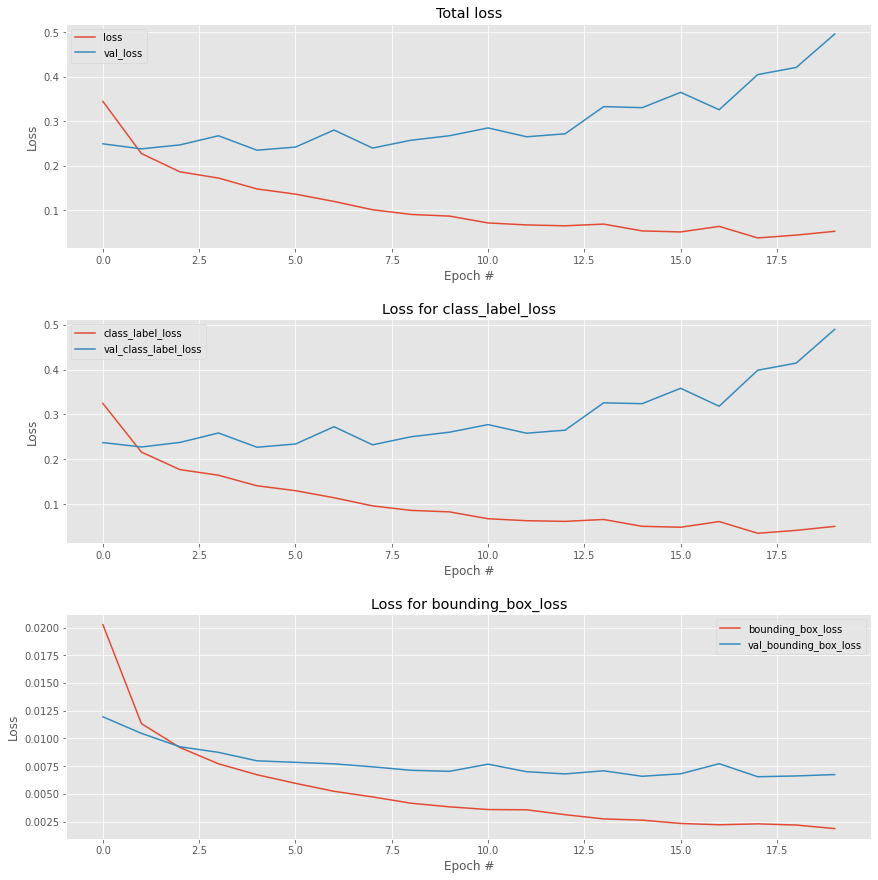

In [94]:
# plotting the total loss, class label loss, and bounding box loss during model training
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
fig.tight_layout(pad=5.0)
plt.savefig('../Images/VGG_16_training_loss_graphs')

# loop over the loss names
for (i, l) in enumerate(loss_names):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

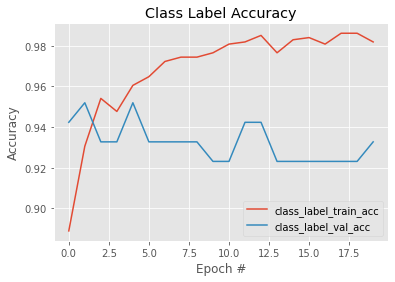

In [95]:
# plotting the class label accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/VGG_16_training_label_accuracy');

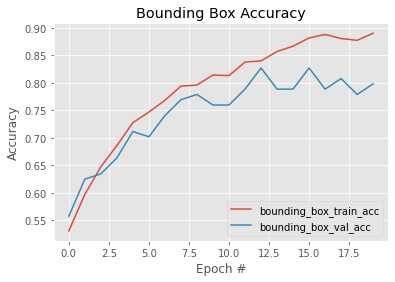

In [102]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/VGG_16_training_bounding_box_accuracy');

### Modeling - ResNet50

In [73]:
# loading ResNet50 network but leaving off output layers
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all resnet layers during training so they are not updated
resnet.trainable = False

# flattening the max-pooling output of resnet
flatten = resnet.output
flatten = Flatten()(flatten)

94773248/94765736 [==============================] - 2s 0us/step


In [75]:
# constructing an output layer to predict bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

In [76]:
# constructing an output layer to predict class labels
class_head = Dense(512, activation="relu")(flatten)
class_head = Dropout(0.5)(class_head)
class_head = Dense(512, activation="relu")(class_head)
class_head = Dropout(0.5)(class_head)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head)

In [77]:
# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_resnet = Model(inputs=resnet.input, outputs=(bbox_head, class_head))

In [78]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

In [79]:
# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

In [80]:
# compiling the model
model_resnet.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_resnet.summary())

Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Model: "functional_6"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
# __________________________________________________________________________________________________
# conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
# __________________________________________________________________________________________________
# conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
# __________________________________________________________________________________________________
# conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
# __________________________________________________________________________________________________
# conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
# __________________________________________________________________________________________________
# pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_relu[0][0]                 
# __________________________________________________________________________________________________
# pool1_pool (MaxPooling2D)       (None, 56, 56, 64)   0           pool1_pad[0][0]                  
# __________________________________________________________________________________________________
# conv2_block1_1_conv (Conv2D)    (None, 56, 56, 64)   4160        pool1_pool[0][0]                 
# __________________________________________________________________________________________________
# conv2_block1_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_1_relu (Activation (None, 56, 56, 64)   0           conv2_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_2_relu (Activation (None, 56, 56, 64)   0           conv2_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_0_conv (Conv2D)    (None, 56, 56, 256)  16640       pool1_pool[0][0]                 
# __________________________________________________________________________________________________
# conv2_block1_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_0_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_add (Add)          (None, 56, 56, 256)  0           conv2_block1_0_bn[0][0]          
#                                                                  conv2_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_out (Activation)   (None, 56, 56, 256)  0           conv2_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv2_block2_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block2_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_1_relu (Activation (None, 56, 56, 64)   0           conv2_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_2_relu (Activation (None, 56, 56, 64)   0           conv2_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_add (Add)          (None, 56, 56, 256)  0           conv2_block1_out[0][0]           
#                                                                  conv2_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_out (Activation)   (None, 56, 56, 256)  0           conv2_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv2_block3_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block3_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_1_relu (Activation (None, 56, 56, 64)   0           conv2_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_2_relu (Activation (None, 56, 56, 64)   0           conv2_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_add (Add)          (None, 56, 56, 256)  0           conv2_block2_out[0][0]           
#                                                                  conv2_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_2_relu (Activation (None, 28, 28, 128)  0           conv3_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_0_conv (Conv2D)    (None, 28, 28, 512)  131584      conv2_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_0_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_add (Add)          (None, 28, 28, 512)  0           conv3_block1_0_bn[0][0]          
#                                                                  conv3_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_out (Activation)   (None, 28, 28, 512)  0           conv3_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block2_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block2_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_1_relu (Activation (None, 28, 28, 128)  0           conv3_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_2_relu (Activation (None, 28, 28, 128)  0           conv3_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_add (Add)          (None, 28, 28, 512)  0           conv3_block1_out[0][0]           
#                                                                  conv3_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_out (Activation)   (None, 28, 28, 512)  0           conv3_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block3_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block3_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_1_relu (Activation (None, 28, 28, 128)  0           conv3_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_2_relu (Activation (None, 28, 28, 128)  0           conv3_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_add (Add)          (None, 28, 28, 512)  0           conv3_block2_out[0][0]           
#                                                                  conv3_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_out (Activation)   (None, 28, 28, 512)  0           conv3_block3_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block4_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block4_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_1_relu (Activation (None, 28, 28, 128)  0           conv3_block4_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block4_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_2_relu (Activation (None, 28, 28, 128)  0           conv3_block4_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block4_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
#                                                                  conv3_block4_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
#                                                                  conv4_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_out (Activation)   (None, 14, 14, 1024) 0           conv4_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block2_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_out[0][0]           
#                                                                  conv4_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_out (Activation)   (None, 14, 14, 1024) 0           conv4_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block3_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block3_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_1_relu (Activation (None, 14, 14, 256)  0           conv4_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_2_relu (Activation (None, 14, 14, 256)  0           conv4_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_add (Add)          (None, 14, 14, 1024) 0           conv4_block2_out[0][0]           
#                                                                  conv4_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_out (Activation)   (None, 14, 14, 1024) 0           conv4_block3_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block4_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block4_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_1_relu (Activation (None, 14, 14, 256)  0           conv4_block4_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block4_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
#                                                                  conv4_block4_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block5_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_2_relu (Activation (None, 14, 14, 256)  0           conv4_block5_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block5_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block5_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_add (Add)          (None, 14, 14, 1024) 0           conv4_block4_out[0][0]           
#                                                                  conv4_block5_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_out (Activation)   (None, 14, 14, 1024) 0           conv4_block5_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block6_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block5_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block6_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_1_relu (Activation (None, 14, 14, 256)  0           conv4_block6_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block6_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_2_relu (Activation (None, 14, 14, 256)  0           conv4_block6_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block6_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block6_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_add (Add)          (None, 14, 14, 1024) 0           conv4_block5_out[0][0]           
#                                                                  conv4_block6_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_out (Activation)   (None, 14, 14, 1024) 0           conv4_block6_add[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_1_conv (Conv2D)    (None, 7, 7, 512)    524800      conv4_block6_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_1_relu (Activation (None, 7, 7, 512)    0           conv5_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_2_relu (Activation (None, 7, 7, 512)    0           conv5_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_0_conv (Conv2D)    (None, 7, 7, 2048)   2099200     conv4_block6_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_0_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_0_bn[0][0]          
#                                                                  conv5_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_out (Activation)   (None, 7, 7, 2048)   0           conv5_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv5_block2_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_out[0][0]           
#                                                                  conv5_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_out (Activation)   (None, 7, 7, 2048)   0           conv5_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv5_block3_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block3_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_1_relu (Activation (None, 7, 7, 512)    0           conv5_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_2_relu (Activation (None, 7, 7, 512)    0           conv5_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_add (Add)          (None, 7, 7, 2048)   0           conv5_block2_out[0][0]           
#                                                                  conv5_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_out (Activation)   (None, 7, 7, 2048)   0           conv5_block3_add[0][0]           
# __________________________________________________________________________________________________
# flatten_2 (Flatten)             (None, 100352)       0           conv5_block3_out[0][0]           
# __________________________________________________________________________________________________
# dense_13 (Dense)                (None, 512)          51380736    flatten_2[0][0]                  
# __________________________________________________________________________________________________
# dense_10 (Dense)                (None, 128)          12845184    flatten_2[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 512)          0           dense_13[0][0]                   
# __________________________________________________________________________________________________
# dense_11 (Dense)                (None, 64)           8256        dense_10[0][0]                   
# __________________________________________________________________________________________________
# dense_14 (Dense)                (None, 512)          262656      dropout_4[0][0]                  
# __________________________________________________________________________________________________
# dense_12 (Dense)                (None, 32)           2080        dense_11[0][0]                   
# __________________________________________________________________________________________________
# dropout_5 (Dropout)             (None, 512)          0           dense_14[0][0]                   
# __________________________________________________________________________________________________
# bounding_box (Dense)            (None, 4)            132         dense_12[0][0]                   
# __________________________________________________________________________________________________
# class_label (Dense)             (None, 2)            1026        dropout_5[0][0]                  
# ==================================================================================================
# Total params: 88,087,782
# Trainable params: 64,500,070
# Non-trainable params: 23,587,712
# __________________________________________________________________________________________________
# None
# ​


In [81]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

In [82]:
# training model for class and bounding box predictions
model = model_resnet.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 60s 2s/step - loss: 0.9634 - bounding_box_loss: 0.0388 - class_label_loss: 0.9246 - bounding_box_accuracy: 0.3729 - class_label_accuracy: 0.5235 - val_loss: 0.7504 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7228 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
Epoch 2/20
30/30 [==============================] - 64s 2s/step - loss: 0.7242 - bounding_box_loss: 0.0270 - class_label_loss: 0.6972 - bounding_box_accuracy: 0.3846 - class_label_accuracy: 0.5577 - val_loss: 0.7114 - val_bounding_box_loss: 0.0264 - val_class_label_loss: 0.6849 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.4327
Epoch 3/20
30/30 [==============================] - 58s 2s/step - loss: 0.6748 - bounding_box_loss: 0.0235 - class_label_loss: 0.6513 - bounding_box_accuracy: 0.4199 - class_label_accuracy: 0.6389 - val_loss: 0.6361 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.6199 - val_bounding_box_ac

In [97]:
# Epoch 1/20
# 30/30 [==============================] - 60s 2s/step - loss: 0.9634 - bounding_box_loss: 0.0388 - class_label_loss: 0.9246 - bounding_box_accuracy: 0.3729 - class_label_accuracy: 0.5235 - val_loss: 0.7504 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7228 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
# Epoch 2/20
# 30/30 [==============================] - 64s 2s/step - loss: 0.7242 - bounding_box_loss: 0.0270 - class_label_loss: 0.6972 - bounding_box_accuracy: 0.3846 - class_label_accuracy: 0.5577 - val_loss: 0.7114 - val_bounding_box_loss: 0.0264 - val_class_label_loss: 0.6849 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.4327
# Epoch 3/20
# 30/30 [==============================] - 58s 2s/step - loss: 0.6748 - bounding_box_loss: 0.0235 - class_label_loss: 0.6513 - bounding_box_accuracy: 0.4199 - class_label_accuracy: 0.6389 - val_loss: 0.6361 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.6199 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9038
# Epoch 4/20
# 30/30 [==============================] - 66s 2s/step - loss: 0.6406 - bounding_box_loss: 0.0166 - class_label_loss: 0.6240 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.6645 - val_loss: 0.6234 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 0.6072 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.8077
# Epoch 5/20
# 30/30 [==============================] - 67s 2s/step - loss: 0.6074 - bounding_box_loss: 0.0157 - class_label_loss: 0.5917 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.6880 - val_loss: 0.6121 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.5975 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.6250
# Epoch 6/20
# 30/30 [==============================] - 71s 2s/step - loss: 0.5780 - bounding_box_loss: 0.0149 - class_label_loss: 0.5630 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.7212 - val_loss: 0.5432 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.5284 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8077
# Epoch 7/20
# 30/30 [==============================] - 76s 3s/step - loss: 0.5445 - bounding_box_loss: 0.0143 - class_label_loss: 0.5302 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.7607 - val_loss: 0.4724 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4585 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 8/20
# 30/30 [==============================] - 76s 3s/step - loss: 0.4926 - bounding_box_loss: 0.0139 - class_label_loss: 0.4787 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.7959 - val_loss: 0.4400 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4260 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9038
# Epoch 9/20
# 30/30 [==============================] - 78s 3s/step - loss: 0.4805 - bounding_box_loss: 0.0136 - class_label_loss: 0.4670 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.8013 - val_loss: 0.4918 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.4782 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.7885
# Epoch 10/20
# 30/30 [==============================] - 75s 3s/step - loss: 0.4688 - bounding_box_loss: 0.0140 - class_label_loss: 0.4548 - bounding_box_accuracy: 0.6378 - class_label_accuracy: 0.7949 - val_loss: 0.3887 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.3754 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 11/20
# 30/30 [==============================] - 77s 3s/step - loss: 0.4545 - bounding_box_loss: 0.0130 - class_label_loss: 0.4415 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.8109 - val_loss: 0.3522 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.3387 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8558
# Epoch 12/20
# 30/30 [==============================] - 80s 3s/step - loss: 0.4134 - bounding_box_loss: 0.0126 - class_label_loss: 0.4008 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.8429 - val_loss: 0.3309 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3178 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 13/20
# 30/30 [==============================] - 77s 3s/step - loss: 0.3981 - bounding_box_loss: 0.0126 - class_label_loss: 0.3855 - bounding_box_accuracy: 0.6485 - class_label_accuracy: 0.8365 - val_loss: 0.3401 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3258 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 14/20
# 30/30 [==============================] - 73s 2s/step - loss: 0.3731 - bounding_box_loss: 0.0129 - class_label_loss: 0.3602 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.8600 - val_loss: 0.3378 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.3242 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 15/20
# 30/30 [==============================] - 74s 2s/step - loss: 0.3846 - bounding_box_loss: 0.0125 - class_label_loss: 0.3721 - bounding_box_accuracy: 0.6186 - class_label_accuracy: 0.8408 - val_loss: 0.3095 - val_bounding_box_loss: 0.0137 - val_class_label_loss: 0.2958 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 16/20
# 30/30 [==============================] - 75s 2s/step - loss: 0.3438 - bounding_box_loss: 0.0122 - class_label_loss: 0.3316 - bounding_box_accuracy: 0.6613 - class_label_accuracy: 0.8686 - val_loss: 0.2833 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.2711 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 17/20
# 30/30 [==============================] - 75s 3s/step - loss: 0.3578 - bounding_box_loss: 0.0122 - class_label_loss: 0.3456 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.8686 - val_loss: 0.3827 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.3696 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8365
# Epoch 18/20
# 30/30 [==============================] - 74s 2s/step - loss: 0.3922 - bounding_box_loss: 0.0121 - class_label_loss: 0.3801 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.8387 - val_loss: 0.3269 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.3149 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 19/20
# 30/30 [==============================] - 76s 3s/step - loss: 0.3502 - bounding_box_loss: 0.0120 - class_label_loss: 0.3381 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.8579 - val_loss: 0.2849 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.2733 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 20/20
# 30/30 [==============================] - 74s 2s/step - loss: 0.3446 - bounding_box_loss: 0.0117 - class_label_loss: 0.3329 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.8825 - val_loss: 0.3997 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.3878 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8462

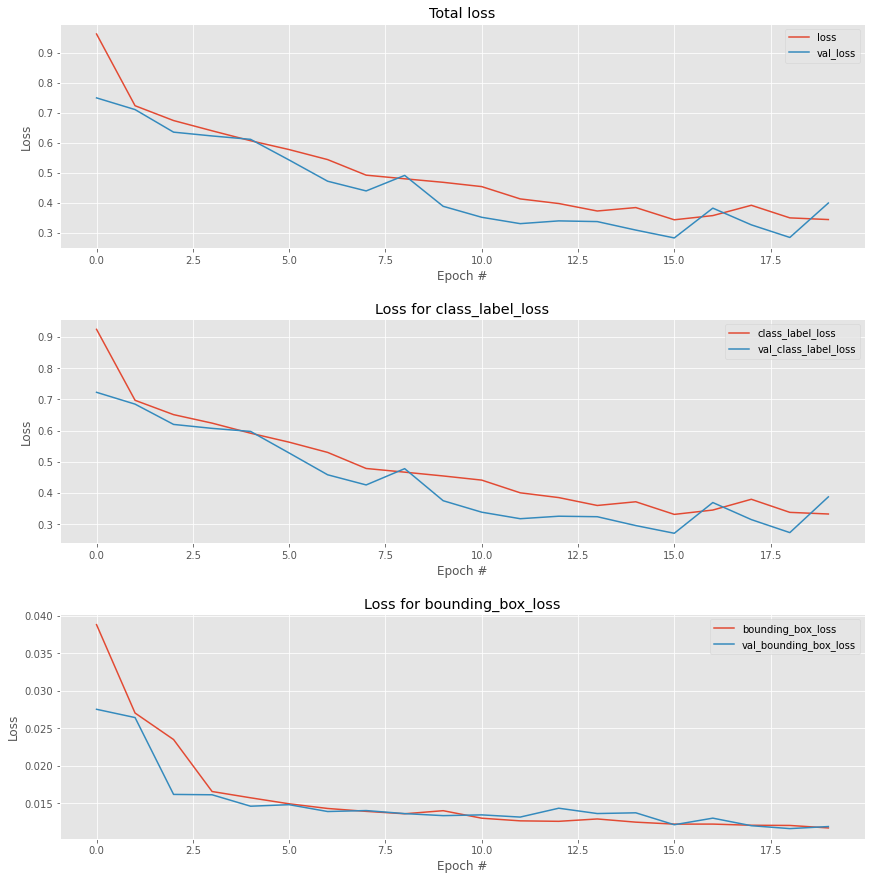

In [98]:
# plotting the total loss, class label loss, and bounding box loss during model training
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
fig.tight_layout(pad=5.0)
plt.savefig('../Images/ResNet_50_training_loss_graphs')

# loop over the loss names
for (i, l) in enumerate(loss_names):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, model.history[l], label=l)
    ax[i].plot(N, model.history["val_" + l], label="val_" + l)
    ax[i].legend()

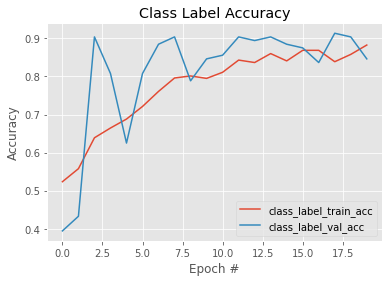

In [99]:
# plotting the class label accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/ResNet_50_training_label_accuracy');

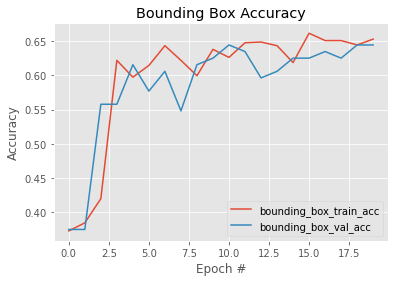

In [101]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/ResNet_50_training_bounding_box_accuracy');

### Modeling - Custom0

In [110]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom0 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

In [111]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

In [112]:
# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

In [113]:
# compiling the model
model_custom0.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom0.summary())

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 32) 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 109, 109, 64) 18496       max_pooling2d_3[0][0]            
______________________________________________________________________________________

In [114]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

In [115]:
# training model for class and bounding box predictions
model = model_custom0.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 31s 1s/step - loss: 0.7689 - bounding_box_loss: 0.0586 - class_label_loss: 0.7103 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.5182 - val_loss: 0.7099 - val_bounding_box_loss: 0.0288 - val_class_label_loss: 0.6812 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4231
Epoch 2/20
30/30 [==============================] - 33s 1s/step - loss: 0.6445 - bounding_box_loss: 0.0230 - class_label_loss: 0.6215 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.6870 - val_loss: 0.5117 - val_bounding_box_loss: 0.0182 - val_class_label_loss: 0.4935 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8365
Epoch 3/20
30/30 [==============================] - 40s 1s/step - loss: 0.4910 - bounding_box_loss: 0.0172 - class_label_loss: 0.4739 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8291 - val_loss: 0.4925 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4785 - val_bounding_box_ac

In [116]:
# Epoch 1/20
# 30/30 [==============================] - 31s 1s/step - loss: 0.7689 - bounding_box_loss: 0.0586 - class_label_loss: 0.7103 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.5182 - val_loss: 0.7099 - val_bounding_box_loss: 0.0288 - val_class_label_loss: 0.6812 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4231
# Epoch 2/20
# 30/30 [==============================] - 33s 1s/step - loss: 0.6445 - bounding_box_loss: 0.0230 - class_label_loss: 0.6215 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.6870 - val_loss: 0.5117 - val_bounding_box_loss: 0.0182 - val_class_label_loss: 0.4935 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8365
# Epoch 3/20
# 30/30 [==============================] - 40s 1s/step - loss: 0.4910 - bounding_box_loss: 0.0172 - class_label_loss: 0.4739 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8291 - val_loss: 0.4925 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4785 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.7596
# Epoch 4/20
# 30/30 [==============================] - 47s 2s/step - loss: 0.4043 - bounding_box_loss: 0.0160 - class_label_loss: 0.3883 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.8590 - val_loss: 0.3618 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3475 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 5/20
# 30/30 [==============================] - 43s 1s/step - loss: 0.3738 - bounding_box_loss: 0.0143 - class_label_loss: 0.3596 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.8718 - val_loss: 0.3910 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.3784 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 6/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.3770 - bounding_box_loss: 0.0137 - class_label_loss: 0.3633 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.8771 - val_loss: 0.3661 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.3543 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 7/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.3283 - bounding_box_loss: 0.0125 - class_label_loss: 0.3158 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.8964 - val_loss: 0.3895 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.3783 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8558
# Epoch 8/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.3175 - bounding_box_loss: 0.0144 - class_label_loss: 0.3031 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.8889 - val_loss: 0.3552 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.3444 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8462
# Epoch 9/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.3026 - bounding_box_loss: 0.0115 - class_label_loss: 0.2910 - bounding_box_accuracy: 0.6581 - class_label_accuracy: 0.8932 - val_loss: 0.4014 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3913 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8365
# Epoch 10/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.2664 - bounding_box_loss: 0.0108 - class_label_loss: 0.2556 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9124 - val_loss: 0.2924 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.2822 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 11/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.2318 - bounding_box_loss: 0.0106 - class_label_loss: 0.2212 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9209 - val_loss: 0.4399 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.4304 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8558
# Epoch 12/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.2326 - bounding_box_loss: 0.0098 - class_label_loss: 0.2228 - bounding_box_accuracy: 0.6870 - class_label_accuracy: 0.9306 - val_loss: 0.2930 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.2841 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 13/20
# 30/30 [==============================] - 40s 1s/step - loss: 0.2010 - bounding_box_loss: 0.0091 - class_label_loss: 0.1919 - bounding_box_accuracy: 0.6859 - class_label_accuracy: 0.9391 - val_loss: 0.4009 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.3915 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8462
# Epoch 14/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1841 - bounding_box_loss: 0.0090 - class_label_loss: 0.1751 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9455 - val_loss: 0.2900 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.2814 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 15/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1559 - bounding_box_loss: 0.0082 - class_label_loss: 0.1477 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9541 - val_loss: 0.2766 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.2682 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 16/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1694 - bounding_box_loss: 0.0079 - class_label_loss: 0.1615 - bounding_box_accuracy: 0.7158 - class_label_accuracy: 0.9391 - val_loss: 0.5298 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.5214 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8077
# Epoch 17/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1462 - bounding_box_loss: 0.0076 - class_label_loss: 0.1386 - bounding_box_accuracy: 0.7233 - class_label_accuracy: 0.9487 - val_loss: 0.3149 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.3065 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 18/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1471 - bounding_box_loss: 0.0075 - class_label_loss: 0.1396 - bounding_box_accuracy: 0.7190 - class_label_accuracy: 0.9626 - val_loss: 0.3097 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3017 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9038
# Epoch 19/20
# 30/30 [==============================] - 37s 1s/step - loss: 0.1012 - bounding_box_loss: 0.0068 - class_label_loss: 0.0944 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 0.9744 - val_loss: 0.3089 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3012 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 20/20
# 30/30 [==============================] - 37s 1s/step - loss: 0.0782 - bounding_box_loss: 0.0064 - class_label_loss: 0.0718 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9797 - val_loss: 0.4372 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.4296 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327

### Modeling - Custom1

In [117]:
# same as model_custom0 but ran for 50 epochs instead of 20

In [120]:
# creating custom model1
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom1 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom1.summary())

Model: "functional_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_12[0][0]           
______________________________________________________________________________________

In [121]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 30s 1s/step - loss: 0.7414 - bounding_box_loss: 0.0320 - class_label_loss: 0.7094 - bounding_box_accuracy: 0.5395 - class_label_accuracy: 0.5534 - val_loss: 0.6915 - val_bounding_box_loss: 0.0202 - val_class_label_loss: 0.6713 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6923
Epoch 2/50
30/30 [==============================] - 32s 1s/step - loss: 0.6689 - bounding_box_loss: 0.0207 - class_label_loss: 0.6482 - bounding_box_accuracy: 0.5438 - class_label_accuracy: 0.6453 - val_loss: 0.6387 - val_bounding_box_loss: 0.0178 - val_class_label_loss: 0.6210 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.6154
Epoch 3/50
30/30 [==============================] - 37s 1s/step - loss: 0.5520 - bounding_box_loss: 0.0165 - class_label_loss: 0.5355 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.8077 - val_loss: 0.4386 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.4251 - val_bounding_box_ac

30/30 [==============================] - 39s 1s/step - loss: 0.0495 - bounding_box_loss: 0.0034 - class_label_loss: 0.0461 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9861 - val_loss: 0.4478 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4402 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
Epoch 25/50
30/30 [==============================] - 39s 1s/step - loss: 0.0442 - bounding_box_loss: 0.0030 - class_label_loss: 0.0412 - bounding_box_accuracy: 0.8237 - class_label_accuracy: 0.9861 - val_loss: 0.3927 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.3855 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
Epoch 26/50
30/30 [==============================] - 39s 1s/step - loss: 0.0579 - bounding_box_loss: 0.0031 - class_label_loss: 0.0548 - bounding_box_accuracy: 0.8259 - class_label_accuracy: 0.9818 - val_loss: 0.3997 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.3922 - val_bounding_box_accuracy: 0

30/30 [==============================] - 36s 1s/step - loss: 0.0125 - bounding_box_loss: 9.7809e-04 - class_label_loss: 0.0115 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9957 - val_loss: 0.8600 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.8530 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
Epoch 48/50
30/30 [==============================] - 36s 1s/step - loss: 0.0408 - bounding_box_loss: 0.0025 - class_label_loss: 0.0382 - bounding_box_accuracy: 0.8622 - class_label_accuracy: 0.9850 - val_loss: 0.5449 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.5365 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
Epoch 49/50
30/30 [==============================] - 36s 1s/step - loss: 0.0212 - bounding_box_loss: 0.0023 - class_label_loss: 0.0189 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9947 - val_loss: 0.5724 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5653 - val_bounding_box_accurac

### Modeling - Custom2

In [ ]:
# same as model_custom0 but ran for 100 epochs instead of 50

In [122]:
# creating custom model2
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom2 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom2.summary())

Model: "functional_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_15[0][0]           
______________________________________________________________________________________

In [123]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 30s 1s/step - loss: 0.7274 - bounding_box_loss: 0.0318 - class_label_loss: 0.6956 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.5716 - val_loss: 0.6067 - val_bounding_box_loss: 0.0194 - val_class_label_loss: 0.5873 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
Epoch 2/100
30/30 [==============================] - 32s 1s/step - loss: 0.5536 - bounding_box_loss: 0.0175 - class_label_loss: 0.5362 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.7991 - val_loss: 0.4606 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.4474 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7981
Epoch 3/100
30/30 [==============================] - 38s 1s/step - loss: 0.4462 - bounding_box_loss: 0.0148 - class_label_loss: 0.4314 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.8408 - val_loss: 0.3969 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.3823 - val_bounding_box

30/30 [==============================] - 37s 1s/step - loss: 0.0797 - bounding_box_loss: 0.0047 - class_label_loss: 0.0751 - bounding_box_accuracy: 0.7991 - class_label_accuracy: 0.9765 - val_loss: 0.3445 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.3376 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
Epoch 25/100
30/30 [==============================] - 36s 1s/step - loss: 0.0781 - bounding_box_loss: 0.0041 - class_label_loss: 0.0740 - bounding_box_accuracy: 0.8269 - class_label_accuracy: 0.9808 - val_loss: 0.4040 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.3961 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
Epoch 26/100
30/30 [==============================] - 36s 1s/step - loss: 0.0493 - bounding_box_loss: 0.0038 - class_label_loss: 0.0456 - bounding_box_accuracy: 0.8365 - class_label_accuracy: 0.9850 - val_loss: 0.4986 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.4917 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0146 - bounding_box_loss: 0.0013 - class_label_loss: 0.0133 - bounding_box_accuracy: 0.8835 - class_label_accuracy: 0.9968 - val_loss: 0.5885 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.5815 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8942
Epoch 48/100
30/30 [==============================] - 36s 1s/step - loss: 0.0115 - bounding_box_loss: 0.0012 - class_label_loss: 0.0103 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9968 - val_loss: 0.5176 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5106 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9135
Epoch 49/100
30/30 [==============================] - 36s 1s/step - loss: 0.0118 - bounding_box_loss: 0.0012 - class_label_loss: 0.0106 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9947 - val_loss: 0.6984 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.6916 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0081 - bounding_box_loss: 6.4217e-04 - class_label_loss: 0.0074 - bounding_box_accuracy: 0.9220 - class_label_accuracy: 0.9979 - val_loss: 0.6513 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.6445 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
Epoch 71/100
30/30 [==============================] - 36s 1s/step - loss: 0.0043 - bounding_box_loss: 5.3410e-04 - class_label_loss: 0.0037 - bounding_box_accuracy: 0.9231 - class_label_accuracy: 0.9989 - val_loss: 0.6872 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.6802 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
Epoch 72/100
30/30 [==============================] - 36s 1s/step - loss: 0.0140 - bounding_box_loss: 0.0011 - class_label_loss: 0.0129 - bounding_box_accuracy: 0.9113 - class_label_accuracy: 0.9947 - val_loss: 0.7606 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.7539 - val_bounding_box_a

30/30 [==============================] - 55s 2s/step - loss: 0.0037 - bounding_box_loss: 3.7856e-04 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.9466 - class_label_accuracy: 0.9979 - val_loss: 0.7521 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.7452 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
Epoch 94/100
30/30 [==============================] - 55s 2s/step - loss: 0.0034 - bounding_box_loss: 3.2175e-04 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.9498 - class_label_accuracy: 0.9989 - val_loss: 0.8294 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.8224 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
Epoch 95/100
30/30 [==============================] - 64s 2s/step - loss: 0.0069 - bounding_box_loss: 3.3348e-04 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.9370 - class_label_accuracy: 0.9979 - val_loss: 0.6552 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.6480 - val_bounding_b

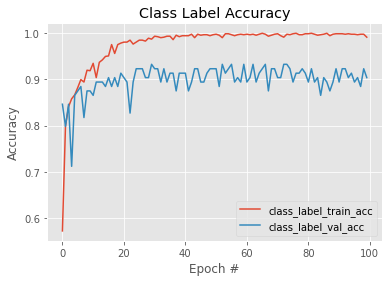

In [124]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom2_training_label_accuracy');

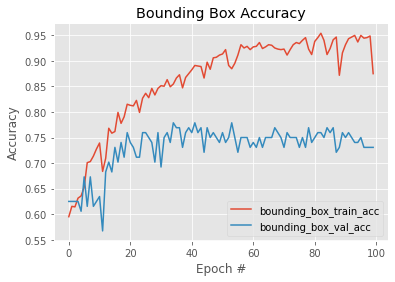

In [126]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom2_training_bounding_box_accuracy');